In [1]:
import pandas as pd

df = pd.read_csv("spam.csv", encoding='latin-1')  # or use encoding='utf-8' if needed
print(df.columns)


Index(['Category', 'Message'], dtype='object')


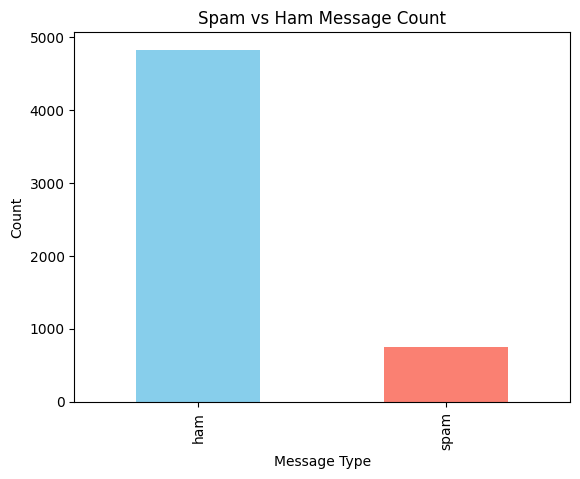


=== Multinomial Naive Bayes ===
Accuracy : 0.962
Precision: 1.000
Recall   : 0.718
F1-Score : 0.836

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.72      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115

Confusion Matrix:
 [[966   0]
 [ 42 107]]

=== Logistic Regression ===
Accuracy : 0.968
Precision: 0.991
Recall   : 0.765
F1-Score : 0.864

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.77      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
 [[965   1]
 [ 35 114]]

=== Linear SV

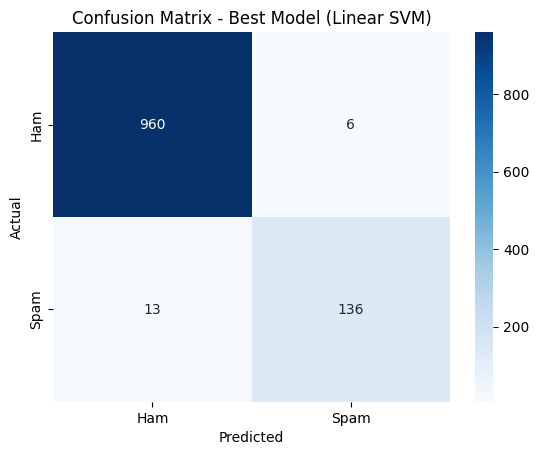


--- Sample Predictions ---
[SPAM] Congratulations! You have won a $1000 Walmart gift card. Click here to claim now.
[HAM ] Are we still meeting at 3pm today?
[HAM ] URGENT: Your account is locked. Verify your details immediately.
[HAM ] Ok, see you soon!
[SPAM] WINNER! You have been selected for a free vacation to the Bahamas. Reply YES to claim.
[SPAM] You have won $500,000 in the lottery. Contact us immediately to collect your prize.
[SPAM] Free entry in 2 a weekly competition to win an iPhone. Text WIN to 12345 now!


In [13]:
# Email Spam Classification 


                                                # Step 1: Import required libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

                       # Imports for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

                                  # Step 2: Download stopwords 
nltk.download('stopwords', quiet=True)

                                 # Step 3: Load the dataset
df = pd.read_csv("spam.csv", encoding="latin-1")  
df = df[['Category', 'Message']]                  
df.columns = ['label', 'text']                    # Rename columns

# Simple Visualization 1: Class Distribution (Spam vs Ham)
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Spam vs Ham Message Count')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

                                 # Step 4: Convert all text to lowercase
df['cleaned_text'] = df['text'].str.lower()

                                # Step 5: Remove punctuation, numbers, and special characters
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^a-z\s]', ' ', x))

                               # Step 6: Tokenize text (split into words), remove stopwords, and apply stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_tokens(sentence):
    tokens = sentence.split()                           
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(t) for t in tokens]          
    return tokens

df['tokens'] = df['cleaned_text'].apply(preprocess_tokens)

                             # Step 7: Join tokens back into full sentence for vectorizer
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

                             # Step 8: Encode labels (ham = 0, spam = 1) for training
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

                             # Step 9: Split into training and testing sets (80% train, 20% test)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['processed_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

                             # Step 10: Convert text into numbers using TF-IDF
tfidf = TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=1)

X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

                             # Step 11: Define models to try
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Linear SVM": LinearSVC()
}

                        # Step 12: Train each model and check performance
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n=== {model_name} ===")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred, pos_label='spam'):.3f}")
    print(f"Recall   : {recall_score(y_true, y_pred, pos_label='spam'):.3f}")
    print(f"F1-Score : {f1_score(y_true, y_pred, pos_label='spam'):.3f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['ham', 'spam']))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred, labels=['ham', 'spam']))

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)                  
    predictions = model.predict(X_test)          
    evaluate_model(y_test, predictions, name)    
    trained_models[name] = model                 

                           # Step 13: Pick best model 
best_model = trained_models["Linear SVM"]

                   # Simple Visualization 2: Confusion Matrix for best model
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best, labels=['ham', 'spam'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model (Linear SVM)')
plt.show()

                                               # Step 14: Test with new unseen messages
sample_messages = [
    "Congratulations! You have won a $1000 Walmart gift card. Click here to claim now.",
    "Are we still meeting at 3pm today?",
    "URGENT: Your account is locked. Verify your details immediately.",
    "Ok, see you soon!",
    "WINNER! You have been selected for a free vacation to the Bahamas. Reply YES to claim.",
    "You have won $500,000 in the lottery. Contact us immediately to collect your prize.",
    "Free entry in 2 a weekly competition to win an iPhone. Text WIN to 12345 now!"
]
sample_vectors = tfidf.transform(sample_messages)
sample_predictions = best_model.predict(sample_vectors)

print("\n--- Sample Predictions ---")
for msg, pred in zip(sample_messages, sample_predictions):
    print(f"[{pred.upper():4}] {msg}")



In [14]:
                            # Step 15: Save the best model and TF-IDF vectorizer
import joblib

# Save model
joblib.dump(best_model, "best_spam_model.joblib")

# Save vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.joblib")

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!
